In [1]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

%matplotlib inline

### define parameters

In [2]:
NUM_SAMPLE = 20000

THRESHOLD = 15
MAX_EDGE = 2000

### read data

In [3]:
with open("train.txt","r") as f:
    lines = f.readlines() 

matrix = {}
for line in tqdm(lines):
    temp = list(map(int, line.split()))
    if len(temp[1:]) > 0:
        matrix[temp[0]] = set(temp[1:])

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:08<00:00, 2289.24it/s]


In [4]:
"""
with open("error.txt","r") as f:
    test = f.readlines()

test_s = set()
test_d = set()
for l in test:
    temp = list(map(int, l.split()))
    test_s.add(temp[0]) ; test_d.add(temp[1])
"""

'\nwith open("error.txt","r") as f:\n    test = f.readlines()\n\ntest_s = set()\ntest_d = set()\nfor l in test:\n    temp = list(map(int, l.split()))\n    test_s.add(temp[0]) ; test_d.add(temp[1])\n'

In [5]:
with open("test-public.txt","r") as f:
    test = f.readlines()

test_s = set()
test_d = set()
for l in test[1:]:
    temp = list(map(int, l.split()))
    test_s.add(temp[1]) ; test_d.add(temp[2])

In [6]:
print(len(test_s), len(test_d), len(matrix))

2000 1978 19570


In [7]:
all_v = {}
for v in tqdm(matrix):
    all_v[v] = all_v.get(v, 0) + 1
    for d in matrix[v]:
        all_v[d] = all_v.get(d, 0) + 1
print(len(all_v))

100%|██████████████████████████████████████████████████████████████████████████| 19570/19570 [00:14<00:00, 1368.66it/s]


4867136


### analyze distribution

1978


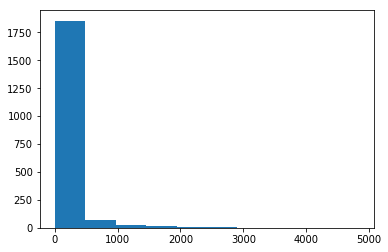

In [8]:
# indegree for sinks in test file
freq = []
for d in test_d:
    freq.append(all_v[d])
freq.sort()
print(len(freq))
plt.hist(freq)
plt.show()

In [9]:
all_freq = list(all_v.values())

In [10]:
print(len([n for n in all_freq if n >= 1 and n <= 5])/len(all_freq))

0.8762763152704177


In [11]:
print(len([n for n in freq if 2 < n <= 6])/len(freq))

0.10212335692618807


In [12]:
"""
sink distribution estimation

start         end    pmf    cdf
        x  <= 2   -- 0.15   0.15  
2    <  x  <= 6   -- 0.1    0.25  
6    <  x  <= 13  -- 0.1    0.35  
13   <  x  <= 25  -- 0.1    0.45  
25   <  x  <= 45  -- 0.1    0.55
45   <  x  <= 70  -- 0.1    0.65
70   <  x  <= 120 -- 0.1    0.75
120  <  x  <= 240 -- 0.1    0.85
240  <  x         -- 0.15   1  
"""
pmf = np.array([0.15] + [0.1] * 7 + [0.15])

### build training set

In [13]:
# divide vertices with indegrees

distri2v = {n:[] for n in range(9)}
v2distri = {}
for v in all_v:
    indegree = all_v[v]
    if indegree <= 2:
        distri2v[0].append(v)
        v2distri[v] = 0
    elif indegree <= 6:
        distri2v[1].append(v)
        v2distri[v] = 1
    elif indegree <= 13:
        distri2v[2].append(v)
        v2distri[v] = 2
    elif indegree <= 25:
        distri2v[3].append(v)
        v2distri[v] = 3
    elif indegree <= 45:
        distri2v[4].append(v)
        v2distri[v] = 4
    elif indegree <= 70:
        distri2v[5].append(v)
        v2distri[v] = 5
    elif indegree <= 120:
        distri2v[6].append(v)
        v2distri[v] = 6
    elif indegree <= 240:
        distri2v[7].append(v)
        v2distri[v] = 7
    else:
        distri2v[8].append(v)
        v2distri[v] = 8

In [14]:
# generate training data
# first sample real edges and record distribution

source = list(matrix.keys())
training_vertex = set()

data = []

distri = np.zeros(9)
max_distri = pmf * NUM_SAMPLE

while len(data) < NUM_SAMPLE//2:
    src = random.choice(source)
    #src = random.sample(test_s, 1)[0]
    dest = random.sample(matrix[src], 1)[0]
    dest_distri = v2distri[dest]
    if distri[dest_distri] < max_distri[dest_distri] and src != dest:
        distri[dest_distri] += 1
        data.append([src, dest, 1])
        training_vertex.add(src)
        training_vertex.add(dest)

print(max_distri)
print(distri)

[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]
[1402. 1074. 1018. 1066. 1046.  803.  866.  944. 1781.]


In [15]:
# sample fake edges and match test distribution

for i in range(len(pmf)):
    while distri[i] < max_distri[i]:
        src = random.choice(source)
        #src = random.sample(test_s, 1)[0]
        dest = random.choice(distri2v[i])
        if dest != src and dest not in matrix[src]:
            data.append([src, dest, 0])
            training_vertex.add(src)
            training_vertex.add(dest)
            distri[i] += 1
random.shuffle(data)

print(max_distri)
print(distri)

[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]
[3000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 3000.]


In [16]:
with open("raw.pickle","wb") as f:
    pickle.dump(data, f)

### no truncate

In [17]:
with open("matrix.pickle","wb") as f:
    pickle.dump(matrix, f)

### truncate graph

In [ ]:
remain = set()

for v in all_v:
    if all_v[v] >= THRESHOLD:
        remain.add(v)

remain = set(remain).union(set(matrix.keys())).union(test_s).union(test_d)#.union(training_vertex)
print(len(remain))

In [ ]:
truncated = {}

for v in tqdm(matrix):
    temp = set()
    for dest in matrix[v]:
        if dest in remain:
            temp.add(dest)
    if len(temp) != 0:
        truncated[v] = temp
    else:
        if v in test_s:
            truncated[v] = matrix[v]

In [ ]:
i, j = 0, 0
for v in truncated:
    if len(truncated[v]) == 0:
        i += 1
        if v in test_s:
            j += 1
print(i, j)

In [ ]:
def count_edge(): 
    l = []
    for v in truncated:
        l.append(len(truncated[v]))
    print("total edge number: {}".format(sum(l)))
    return l

In [ ]:
l = count_edge()
plt.hist(l)
plt.show()

In [ ]:
for v in tqdm(truncated):
    destination = list(truncated[v])
    if len(destination) > MAX_EDGE:
        cut_edge = sorted(destination, key=lambda x: all_v[x], reverse=True)[:MAX_EDGE]
        truncated[v] = set(cut_edge)
l = count_edge()

In [ ]:
with open("matrix.pickle","wb") as f:
    pickle.dump(truncated, f)

In [ ]:
data = []
source = list(truncated.keys())
remain_list = list(remain)

while len(data) < NUM_SAMPLE//2:
    src = random.choice(source)
    dest = random.sample(truncated[src], 1)[0]
    if src != dest:
        data.append([src, dest, 1])
print("half done")

while len(data) < NUM_SAMPLE:
    src = random.choice(source)
    dest = random.choice(remain_list)
    while dest == src or dest in truncated[src]:
        dest = random.choice(remain_list)
    data.append([src, dest, 0])

with open("raw.pickle","wb") as f:
    pickle.dump(data, f)